# Final Notebook


In [82]:
# Imports

# interactive widget imports
import ipywidgets as wg
from IPython.display import display
import pickle

# data handling modules
import pandas as pd
import numpy as np
from datetime import datetime

# plotting imports
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='Flavioh', api_key='GogTSHQAuhgi5p724TsF')
plt.style.use('seaborn')

# web scraping
from bs4 import BeautifulSoup
import requests

from scipy.stats import wilcoxon

# other helpers and suppress warnings
from helpers import *
from timeline_helpers import *
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

## *Data Cleaning*

### Columns description

In [6]:
tweets1 = pd.read_csv('../data/' + 'IRAhandle_tweets_1.csv')
tweets1.head(1)

/Users/benjaminfuhrer/Downloads/GitHub/Adarmonic_mean_project./data/


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll


For a proper description of each column go here: https://www.kaggle.com/fivethirtyeight/russian-troll-tweets/home

Out of these colums we have no interest in **harvested_date** and **new_june_2018**, since they contain information concerning the collection of the data and not the content itself.

In [4]:
cols_to_extract = [0,1,2,3,4,5,7,8,9,10,11,13,14]

### Data extraction

In [7]:
tweets1 = pd.read_csv('../data/' + 'IRAhandle_tweets_1.csv', usecols=cols_to_extract)
tweets2 = pd.read_csv('../data/' + 'IRAhandle_tweets_2.csv', usecols=cols_to_extract)
tweets3 = pd.read_csv('../data/' + 'IRAhandle_tweets_3.csv', usecols=cols_to_extract)
tweets4 = pd.read_csv('../data/' + 'IRAhandle_tweets_4.csv', usecols=cols_to_extract) 
tweets5 = pd.read_csv('../data/' + 'IRAhandle_tweets_5.csv', usecols=cols_to_extract)
tweets6 = pd.read_csv('../data/' + 'IRAhandle_tweets_6.csv', usecols=cols_to_extract)
tweets7 = pd.read_csv('../data/' + 'IRAhandle_tweets_7.csv', usecols=cols_to_extract) 
tweets8 = pd.read_csv('../data/' + 'IRAhandle_tweets_8.csv', usecols=cols_to_extract) 
tweets9 = pd.read_csv('../data/' + 'IRAhandle_tweets_9.csv', usecols=cols_to_extract)

In [8]:
tweets = pd.concat([tweets1,tweets2,tweets3,tweets4,tweets5,tweets6,tweets7,tweets8,tweets9], axis=0)
tweets.head(1)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,0,RightTroll


In [9]:
# delete not needed variables from memory
del tweets1
del tweets2
del tweets3
del tweets4
del tweets5
del tweets6
del tweets7
del tweets8
del tweets9

### Data formats

The different data columns are transformed into appropriated data type:

+ external_author_id, author, region, language, post_type, account_type, retweet, account_category to categorical;
+ publish_date to datetime;
+ content (the actual tweet) to string type;
+ int64 types are left as int64 since they are counting variables.




In [10]:
#complete post_type column with normal tweet category
tweets.post_type.fillna('TWEET', inplace=True)

tweets['content'] = tweets.content.astype(str)

tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']] = \
tweets[['external_author_id', 'author', 'region', 'language', 'post_type', 'account_type', 'retweet', 'account_category']].astype('category')

tweets['publish_date'] = pd.to_datetime(tweets['publish_date'], format='%m/%d/%Y %H:%M')

tweets.dtypes

external_author_id          category
author                      category
content                       object
region                      category
language                    category
publish_date          datetime64[ns]
following                      int64
followers                      int64
updates                        int64
post_type                   category
account_type                category
retweet                     category
account_category            category
dtype: object

## Dataset description

### General Numbers and Statistics

In [11]:
print('The total number of tweets in the unfiltered dataset is {}'.format(tweets.shape[0]))

The total number of tweets in the unfiltered dataset is 2973371


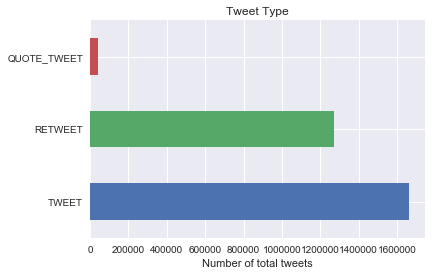

In [12]:
# retweets vs not retweets vs quotes
tweets.post_type.value_counts().plot.barh()
plt.title('Tweet Type')
plt.xlabel('Number of total tweets')
plt.show()

From this plot, we can observe the distribution of the tweets with respect to the originality of the content. 

We can visualize how the number of retweets is almost at par with the number of original tweets. This is particularly of interest because it could have been an automated action to save the Russian trolls' time while broadcasting their messages.

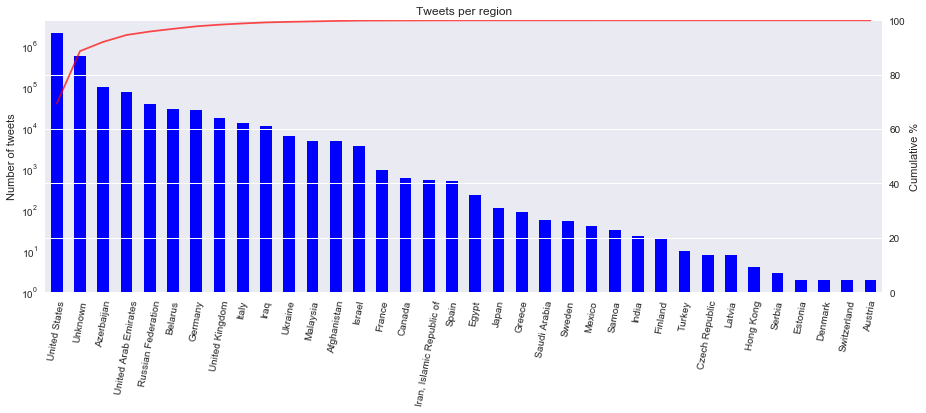

In [13]:
# Show plot region
fig = plt.figure(num=None, figsize=(15, 5))
tweets.region.value_counts().plot.bar(log = True, color = 'blue')
plt.ylabel('Number of tweets')
plt.title('Tweets per region')
plt.xticks(rotation=80)
plt.grid(False)
ax2 = fig.gca().twinx()
ax2.plot(tweets.region.value_counts().values.cumsum()/tweets.region.value_counts().values.sum()*100, color='red', alpha=0.7)
ax2.set_ylabel('Cumulative %')
ax2.set_ylim([0, 100])
plt.show()

According to the barplot, there are 35 different regions from which the tweets originated. Note that the plot is in a logarithmic scale, implying that around 75% of the tweets originated in the United States and around 90% from US + unknown region. The rest of the countries demonstrate how the Russian Trolls did their best to hide the fact that they had been tampering with the Twitter Feed.

### Authors and followers

Authors are defined by their twitter username. To understand to what extent a single author can influence the Twitter newsfeed, one needs to take into consideration different aspects:

+ each author reaches through time different followers, which is a quantity that shows how many people could have potentially read the author's tweets
+ each author has been assigned to a certain account_category that defines the troll's purpose and main tweeting subject


There are 2848 unique authors. Divided in categories in this way:


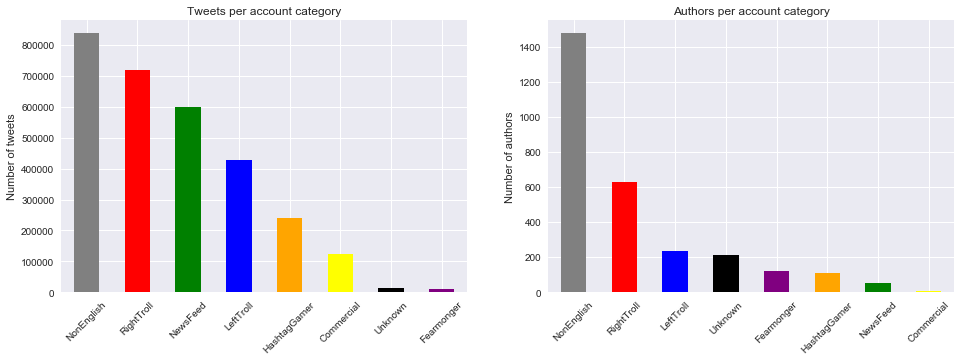

In [14]:
print('There are {} unique authors. Divided in categories in this way:'
      .format(tweets.author.cat.categories.shape[0]))

# Show bar chart of proportions of account categories
category_map = {'RightTroll' : 'red',
               'NewsFeed' : 'green',
               'LeftTroll' : 'blue',
               'NonEnglish' : 'grey',
               'Fearmonger' : 'purple',
               'HashtagGamer' : 'orange',
               'Unknown' : 'black',
               'Commercial' : 'yellow'}

color_map =map(lambda cat: category_map.get(cat), tweets.account_category.value_counts().index)

plt.figure(num=None, figsize=(16, 5))
plt.subplot(1,2,1)
tweets.account_category.value_counts().plot.bar(color=color_map)
plt.ylabel('Number of tweets')
plt.title('Tweets per account category')
plt.xticks(rotation=45)

# Show bar chart of proportions of account categories
plt.subplot(1,2,2)
color_map =map(lambda cat: category_map.get(cat), tweets[['author','account_category']].drop_duplicates().account_category.value_counts().index)

tweets[['author','account_category']].drop_duplicates().account_category.value_counts().plot.bar(color=color_map)
plt.ylabel('Number of authors')
plt.title('Authors per account category')
plt.xticks(rotation=45)
plt.show()

From the plot of account categories of total tweets on the left, it is clear that the majority of tweets are in fact not English. Furthermore, minority groups include HashtagGamer, Commercial and Fearmongers. For these reasons, the rest of our analysis has a greater focus on the RightTroll, LeftTroll and sometimes NewsFeed categories. There will be greater analysis of the NewsFeed at a later milestone.

From the plot on the right, knowing that each author can belong to only one category (with the exception of fearmonger) we can say that around 1500 authors only post in a non-English language. We can also observe that the biggest difference with the preceding figure that compared the categories of the total tweets is that the NewsFeed category has very few dedicated authors. This implies that those authors involved in NewsFeed tend to tweet significantly more.

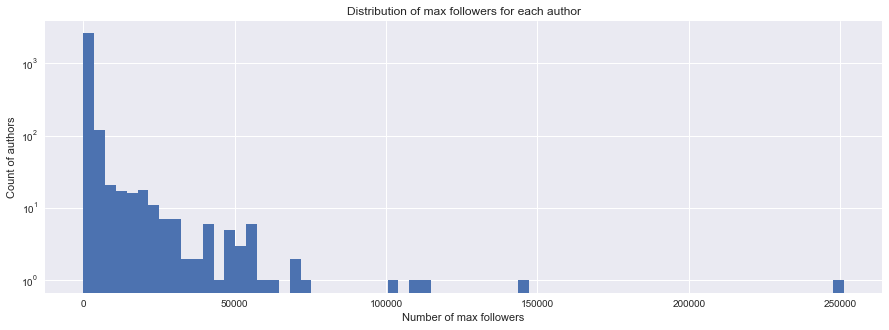

In [15]:
plt.figure(num=None, figsize=(15, 5))

tweets.groupby('author')['followers'].max().dropna().hist(log=True, bins=70)
plt.title('Distribution of max followers for each author')
plt.xlabel('Number of max followers')
plt.ylabel('Count of authors')

plt.show()

In [16]:
# Compute median and average max followers

tweets.groupby('author')['followers'].max().dropna().describe()

count      2848.000000
mean       1938.782303
std        8885.910525
min           0.000000
25%          65.000000
50%         171.500000
75%         728.250000
max      251276.000000
Name: followers, dtype: float64

It appears that there are few authors that have significantly higher number of maximum followers throughout their career. The average author has a median of 171 followers. Compare this to the author with the most followers, which is 251276. This may indicate that the great majority of accounts were not influential, in the sense that their tweets were not read by a considerable amount of people. 

In [17]:
print('NB: The user can toggle the other categories not displayed.')

data = []

for cat in reversed(tweets.account_category.cat.categories):

    acc_cat = tweets[['author','followers']][tweets.account_category == cat]
    extracted_followers = acc_cat.groupby('author')['followers'].max().dropna().values
    
    if(cat == 'RightTroll' or cat=='LeftTroll'):
        trace = go.Box(
                    y=extracted_followers[extracted_followers>0],
                    name=cat,
                    boxpoints='all'
        )
    
    else:
        trace = go.Box(
                        y=extracted_followers[extracted_followers>0],
                        name=cat,
                        boxpoints='all',
                        visible= 'legendonly'
                )
    
    data.append(trace)
    
layout = go.Layout(title = 'Distribution of account followers per category',
                   yaxis=dict(type='log',autorange=True,showgrid=True))
    
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart1')

NB: The user can toggle the other categories not displayed.


/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [2]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

fig = py.get_figure('https://plot.ly/~Flavioh/54', raw=True)
iplot(fig)

Interestingly we see that for categories 'RightTroll', 'LefTroll' and 'HashtagGamer' seem to have a logarithmic bimodal distribution of number of followers per account. Specifically for left and right troll there seem to be a population around 100 followers and another around 1000 followers, we currently cannot explain where this two populations may come from.n, 

In addition, we can see that the NewsFeed accounts have many more followers, perhaps because they may be more 'neutral'

## Tweets Over Time

### *General Timeline Analysis*

In [18]:
# Tweets over time
# add numerical column of ones to symbolize a tweet
tweets['tweet_counts'] = np.ones(tweets.shape[0])

# See if i can extract, within each date interval, an authors max followers value
group_followers = tweets.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                  'author'])['followers'].max().groupby(level=0).sum()
group_following =tweets.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                 'author'])['following'].max().groupby(level=0).sum()
group_authors_time = pd.DataFrame({'followers': group_followers.values,
                                   'following': group_following.values},
                                  index=group_followers.index.values)
  
# group by month
general_timeline = tweets.groupby(pd.Grouper(key='publish_date', freq='1M')).sum()
# construct labels
xlabels = list(pd.Series(group_authors_time.index.strftime(
    '%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7]))
data = []

for col in group_authors_time:
    filtered = group_authors_time[col].copy()
    trace = go.Scatter(x=xlabels, y=filtered.values, name=col, 
                       fill='tozeroy', mode='lines')
    data.append(trace)

filtered = general_timeline['tweet_counts'].copy()
trace=go.Scatter(x=xlabels, y=filtered.values, marker = {'color' : '#00AA00'}, name='Tweet Counts', fill='tozeroy', mode='lines')
data.append(trace)

trace=go.Scatter(x=['2016-11-08','2016-11-08'], y=[0,3500000], marker = {'color' : '#FF0000'}, name='Election day', fill='tozeroy', mode='lines')
data.append(trace)

trace=go.Scatter(x=['2016-11-08','2016-11-08'], y=[0,200000], marker = {'color' : '#FF0000'}, name='Election day', fill='tozeroy', mode='lines')
data.append(trace)

In [16]:
# Create plots for following, followers, updates, tweet_counts

fig = tools.make_subplots(rows=2, cols=1)

fig.append_trace(data[0], 1, 1)
fig.append_trace(data[1], 1, 1)
fig.append_trace(data[3], 1, 1)
fig.append_trace(data[2], 2, 1)
fig.append_trace(data[4], 2, 1)

fig['layout'].update(height=600, width=800, title='General Trends Across Time')
py.iplot(fig, filename='chart2')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [3]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/56', raw=True)
iplot(fig)

From these time series graphs, one can visualize how the number of followers (on a monthly basis) for unique authors increases rather constantly while the number of following accounts stays approximately constant. Additionally, when comparing the number of tweets that were released over time do not seem to infuence the increase in followers when the data is taken as a whole and not analyzed by the populations within, such as account categories.

It is also apparent that there are prominent peaks in the timeseries of the number of tweets. Three of these peaks are of particular interest to this project. The first peak is between August and September of 2015, the second is in the beginning of 2016 and the last occurred the month during the elections (November 8th). These time periods are analyzed in more detail below.
What happened after the election day is of no interest for this project.

### *Language Timeline Analysis*

In [19]:
langs = tweets.language.value_counts().iloc[0:13].index.tolist()
print('The top 13 languages are:\n{}'.format(langs)) # top 13 list

The top 13 languages are:
['English', 'Russian', 'German', 'Ukrainian', 'Italian', 'Serbian', 'Uzbek', 'Bulgarian', 'LANGUAGE UNDEFINED', 'Arabic', 'Macedonian', 'French', 'Spanish']


In [20]:
language_time = tweets[(tweets.publish_date > '2015') & (tweets.publish_date < '2016-12-02')][['language', 'publish_date']]

In [19]:
data = trace_generator_language(language_time)
layout = do_layout('Date', 'Number of Tweets', 'Language as a Function of Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart3')

In [4]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/58', raw=True)
iplot(fig)

In [20]:
# Normalized
data = []

for lang in langs:

    filtered=count_language(lang, language_time)
    strd = pd.Series(filtered.index.strftime('%Y-%m-%d %H-%M-%S'))
    xlabels = list(strd.apply(lambda x: x[0:7]))
    
    trace = dict(
        x=xlabels,
        y=filtered.values,
        mode='lines',
        stackgroup='one',
        groupnorm='percent',
        name = lang,
    )
    
    data.append(trace)

layout = do_layout('Date', 'Fraction of Tweets (%)','Language of Tweets by Month')
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='chart4', validate=False)

In [5]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/60', raw=True)
iplot(fig)

These graphs show that the proportion of tweets by language can fluctuate quite a lot. While English and Russian remain the most dominant languages, there are some peaks affiliated with more uncommon languages including but not limited to German, Ukranian and Italian. These smaller peaks may correlate with news events that were occuring around the globe. 

One scenario where this could be the case would be the peak for the German language, which starts around May 2016. In June 2016, Trump was in Scotland for the Brexit event where he praised the movement. This made the Germans outraged, which caused a backlash. The peak in German tweets therefore may be linked in some way to this event.

To our surprise, very few spanish tweets have been released, considering the fact that spanish is the second most prominent language in the U.S.

### *Account Category Timeline Analysis*

In [21]:
# descriptions of publish dates per category

# Since the values of tweets are minimal before 2015 filter dataframe
tweets_processed = tweets.copy()
#create dataframe with publish date and account type
accounttype_time = tweets_processed[['publish_date', 'account_category']]

data = trace_generator_account_dense(accounttype_time)
layout = do_layout('Date', 'Number of Tweets','Account Type of Tweets by day')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart5')

In [6]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/62', raw=True)
iplot(fig)

From the analysis of the most prominent spikes in this graph, it is likely that such spikes are linked to specific events from which we can infer (with further analysis) specific locations or topics treated. One such example is that of the Brexit event - see the description below. Some of these spikes will be better taken into consideration when we will tell our data story.

Fearmonger accounts only tweeted on specific days (toggle the legend), of which the reason behind can be discovered by further investigation during those days. Hashtag accounts have a different distribution - commencing in 2015 with some spikes, decreasing for a period and suddenly becoming very active a few months before the election. This may have been an interesting tactic to lure young adults.

Commercial tweets are very exclusive for the reason that they mostly only occurred before September 2015, making it one of the earliest account types. This raises the difficult question of whether they were established to influence the American population or not, and hence if it is useful to investigate for our research question. They may however have posed as a way for the IRA to understand population tendencies on Twitter. 

Left trolls have a huge peak just one month before the election, precisely on Oct 6 2016: the evacuation of Florida and South Carolina from a hurricane.

Interestingly, NewsFeed accounts have an oscillatory behaviour due to a diminished activity during the weekends. We speculate that some of those trolls are working only on weekdays, almost like a normal job.

In [23]:
# Since the general timeline analysis tweets indicate that there are hardly any tweets 
# before the year 2015, a new dataset is created that filters for 2015 onwards

# Since the values of tweets are minimal before 2015 filter dataframe
tweets_processed = tweets[(tweets.publish_date > '2015')
                          & (tweets.publish_date < '2016-12-01')].copy()
#create dataframe with publish date and account type
accounttype_time = tweets_processed[['publish_date', 'account_category']]

data = trace_generator_account(accounttype_time)
layout = do_layout('Date', 'Fraction of Tweets(%)','Account Type of Tweets by Month')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart6')

In [7]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/64', raw=True)
iplot(fig)

This graph may help to further investigate proportions between categories, something worth mentioning is how right trolls tweeted much more than left trolls up to 4 or 5 months before the election.

In [24]:
# Create dataframes for left and right trolls
righttroll = tweets_processed[tweets_processed.account_category
                              == 'RightTroll'][['author', 'publish_date',
                                                'tweet_counts', 'followers']]
lefttroll = tweets_processed[tweets_processed.account_category
                             == 'LeftTroll'][['author','publish_date',
                                              'tweet_counts','followers']]


# Create dataframe for right trolls
group_followers_right = righttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                  'author'])['followers'].max().groupby(level=0).sum()
group_tweets_right =righttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                 'author'])['tweet_counts'].sum().groupby(level=0).sum()
group_right = pd.DataFrame({'followers': group_followers_right.values,
                                   'tweets': group_tweets_right.values},
                                  index=group_followers_right.index.values)
#Create dataframe for left trolls

group_followers_left = lefttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                  'author'])['followers'].max().groupby(level=0).sum()
group_tweets_left =lefttroll.groupby([pd.Grouper(key='publish_date', freq='1M'),
                                 'author'])['tweet_counts'].sum().groupby(level=0).sum()
group_left = pd.DataFrame({'followers': group_followers_left.values,
                                   'tweets': group_tweets_left.values},
                                  index=group_followers_left.index.values)

trace0 = go.Scatter(
    x=list(pd.Series(group_right.index.strftime('%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7])),
    y=group_right.followers.values,
    mode='markers',
    name='Right Troll',
    marker=dict(
        size= group_right.tweets.values * 0.002,
        sizemode='diameter',
        sizeref=2,
        sizemin=4))

trace1 = go.Scatter(
    x=list(pd.Series(group_left.index.strftime('%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7])),
    y=group_left.followers.values,
    mode='markers',
    name='Left Troll',
    marker=dict(
        size=group_left.tweets.values * 0.002,
        sizemode='diameter',
        sizeref=2,
        sizemin=4))

data = [trace0, trace1]
layout = do_layout('Date','Number of Followers in Category',
                   'Social Power (#Tweets = diameter) of Categories by Month')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart7')

In [8]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/66', raw=True)
iplot(fig)

The comparison between the authors that are labelled as Right Troll and Left Troll are compared in this bubble chart with respect to their popularity. Popularity in this case in based upon how many followers a given author has during the period of time. The size of the bubbles corresponds to the amount of tweets that are released. It appears that Left Trolls began releasing larger quantities of tweets right before the election, with fewer followers, while Right Trolls began releasing tweets in greater quantities more than a year ago, which may have helped them gain more followers in the long run. From a different perspective it could also imply that the subject matter of Right Trolls was more appealing for the general public.

### Investigating Retweets

In [25]:
RIGHT_TROLL = tweets_processed[tweets_processed.account_category
                              == 'RightTroll'][['author', 'publish_date',
                                                'tweet_counts', 'followers', 'retweet']].copy()
LEFT_TROLL = tweets_processed[tweets_processed.account_category
                             == 'LeftTroll'][['author','publish_date',
                                              'tweet_counts','followers','retweet']].copy()


In [31]:
print('The total tweets of right trolls are {} and the total tweets of left trolls\
is {}'.format(RIGHT_TROLL.shape[0], LEFT_TROLL.shape[0]))

print('The total proportion of retweets for right trolls is {} while the proportion\
for retweets of left trolls is {}'.format(
   RIGHT_TROLL[RIGHT_TROLL.retweet == 1].shape[0]/RIGHT_TROLL.shape[0],
LEFT_TROLL[LEFT_TROLL.retweet == 1].shape[0]/LEFT_TROLL.shape[0]))

The total tweets of right trolls are 289240 and the total tweets of left trollsis 210925
The total proportion of retweets for right trolls is 0.5852786613193196 while the proportionfor retweets of left trolls is 0.7449567381770772


In [32]:
# Do line chart that demonstrates the percentage of retweets over time for the 2 categories
tweets_month_right = RIGHT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts().groupby(level=0).sum()
retweet_right = RIGHT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts()

retweets_array_right = retweet_right.loc[(retweet_right.index.get_level_values('retweet') == 0)].values

# Do same for left trolls

tweets_month_left = LEFT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts().groupby(level=0).sum()
retweet_left = LEFT_TROLL.groupby(
    pd.Grouper(key='publish_date', freq='1M'))['retweet'].value_counts()

retweets_array_left = retweet_left.loc[(retweet_left.index.get_level_values('retweet') == 0)].values
    

In [33]:
percentage_not_retweet = pd.DataFrame({
    'Right Trolls':retweets_array_right/tweets_month_right.values * 100,
'Left Trolls' : retweets_array_left/tweets_month_left.values * 100},
    index=tweets_month_left.index.values)


In [34]:
# Plotting the change in normal tweets (not retweets)

# construct labels
xlabels = list(pd.Series(percentage_not_retweet.index.strftime(
    '%Y-%m-%d %H-%M-%S')).apply(lambda x: x[0:7]))
data = []

for col in percentage_not_retweet:
    filtered = percentage_not_retweet[col].copy()
    trace = go.Scatter(x=xlabels, y=filtered.values, name=col, mode='lines')
    data.append(trace)


In [29]:
layout = do_layout('Date', 'Percent of Original Tweets', 'Proportion of Retweets Over Time')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart8')

In [9]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/68', raw=True)
iplot(fig)

From the proportions of retweets among the two popular categories, RightTroll and LeftTroll, we can see that the proportions do correlate quite well until mid 2016 up until the election. During this period the proportion of retweets becomes much greater for the LeftTrolls (the percent of Original Tweets shrinks). The reason for this is still unclear and requires more investigation. With the use of a subject categorizer we may be able to explain why (milestone 3), for example if the subjects are always the same, it may be worthwhile simply retweeting rather than writing original content.

### Investigating Change in Account Category Over Time

In [35]:
# For each author, find dates of first 5 tweets, 5 tweets in November 2016, 5 last tweets

# Find authors that posted in November 2016
nov2016 = tweets_processed[(tweets_processed.publish_date > '2016-11-01')
                                  & (tweets_processed.publish_date < '2016-11-08')]
authors_nov2016 = nov2016.author.unique().categories.values

# create dataframe with only authors that posted during the week of the election
tweets_with_authors_election = tweets_processed[tweets_processed.author.isin(authors_nov2016)]

# Dataframe of authors of interest in first tweet wave
jul2015 = tweets_with_authors_election[(tweets_with_authors_election.publish_date
                                                > '2015-07-01') & 
                                               (tweets_with_authors_election.publish_date
                                                < '2015-08-01')]



In [36]:
tweets_with_authors_election.shape, jul2015.shape, nov2016.shape

((929475, 14), (17812, 14), (24256, 14))

In [37]:
# Visualize the distribution of account categories between the two selected periods

jul2015_grouping = jul2015.groupby('account_category').sum()
nov2016_grouping = nov2016.groupby('account_category').sum()

In [38]:
tweet_change = pd.DataFrame([jul2015_grouping.tweet_counts, nov2016_grouping.tweet_counts])
tweet_change.index = ['jul2015', 'nov2016']
tweet_change.drop(columns=['Commercial', 'Fearmonger','Unknown'], inplace=True)

# Show a percent change between the two time frames
percent_change = (nov2016_grouping - jul2015_grouping)/jul2015_grouping*100
percent_change.dropna(inplace=True)


In [39]:
data = []
xlabels = ['July 2015', 'November 2016']
for col in tweet_change:
    filtered = tweet_change[col]
    trace = go.Scatter(x=xlabels,y=filtered.values,
                       fill='tozeroy',mode= 'none',name=col)
    data.append(trace)
    

In [35]:
layout = do_layout('Time Period', 'Number of Tweets',
                   'Account Categories Between Two Time Periods of Identical Author Groups')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='chart9')




In [10]:
######################################################################################################################
#TO VISUALIZE THE PLOT FROM THE CLOUD RUN THIS CELL #######################################
###############################################################################################################################

fig = py.get_figure('https://plot.ly/~Flavioh/70', raw=True)
iplot(fig)

This plot has two time periods in which the authors that are selected post tweets in both periods. It is interesting to note that the only account category which decreased its number of tweets was NewsFeed.

# Semi-Supervised Learning Neural Classifier 

Notebook where it can be found and description

# Data Transformation 

Notebook where it can be found and description

# Which States Are Targetted?

## Load Data Dictionary

In [51]:
data = pd.read_csv('../data/' + 'final_dataset.csv')
data.head()

,Unnamed: 0,author,publish_date,following,followers,post_type,account_category,reply_count,like_count,retweet_count,hashtags,topic,topic_scores,tweet_text
0,1,1D_NICOLE_,2015-11-26 22:20:00,48,40,RETWEET,Fearmonger,0.0,0.0,15.0,"[FoodPoisoning, Walmart, KochFarms]",Trump,[-8.1184225 -4.818271 -2.6408563 -0.574982...,#FoodPoisoning is not a joke! #Walmart #KochFa...
1,2,1D_NICOLE_,2015-11-26 22:35:00,48,40,RETWEET,Fearmonger,1.0,0.0,20.0,"[turkey, KochFarms]",Patriot,[ -9.862805 -4.7526827 4.4411793 -10.09800...,Thanks God that #turkey i ate few days ago was...
2,3,1D_NICOLE_,2015-09-06 15:26:00,59,53,TWEET,Fearmonger,0.0,0.0,0.0,[DumbGenieWishes],Trump,[-5.468153 -3.8110754 0.38878125 -7.120957...,I want my little parrot to speak at last!!! #D...
3,4,1D_NICOLE_,2015-09-06 15:30:00,59,53,TWEET,Fearmonger,0.0,0.5,0.0,[DumbGenieWishes],Black,[-3.9203706 -1.6616256 -0.85534257 -3.182626...,An everyday changing funny church sign #DumbGe...
4,5,1D_NICOLE_,2015-09-06 15:33:00,59,53,TWEET,Fearmonger,0.0,0.5,0.0,"[YoLandi, DumbGenieWishes]",Black,[-7.635078 -1.9815104 -0.70070666 -4.231632...,I wish look like #YoLandi #DumbGenieWishes


## Load State Dictionary

In [52]:
with open('../generated/state_n_city.pickle', 'rb') as handle:
    state_n_city_dict = pickle.load(handle)
code_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
            'ME', 'MD', 'MA', 'MI','MN', 'MS', 'MO','MT','NE','NV', 'NH',  'NJ','NM', 'NY','NC','ND','OH','OK',
            'OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

## Extracting tweets per swing state

In [53]:
state_tweet = dict()
for state in state_n_city_dict.keys():
    state_tweet[state] = data.loc[data.tweet_text.str.contains(state_n_city_dict[state]), :]

## Number of tweets mentioning each state

In [54]:
# print number of tweets per swing state
nb_tweets_per_state = dict()
for state, code in zip(state_tweet.keys(), code_list):
    if state_tweet[state].shape[0] > 0:
        nb_tweets_per_state[code] = (state_tweet[state].shape[0])
nb_tweets_per_state = pd.Series(data=nb_tweets_per_state)

In [ ]:
_data = [ dict(
        type='choropleth',
        autocolorscale = True,
        locations = nb_tweets_per_state.index,
        z = nb_tweets_per_state.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "")
        ) ]
layout = dict(
        title = 'Number of tweets mentioning each swing state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = False))
fig = dict( data=_data, layout=layout)
py.iplot( fig, filename='d3-cloropleth-map' )

## Left/Right Troll per state 

In [57]:
def series_string_to_datetime(series):
    format_str = '%Y-%m-%d %H:%M:%S' # The format
    return series.apply(lambda x: datetime.strptime(x, format_str))
data.publish_date = series_string_to_datetime(data.publish_date)

In [58]:
monthly_spaced_df = []
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']
dates = []
for year in [2015, 2016]:
    for month in range(12):
        if not data[(data['publish_date'].dt.month == month + 1) & 
                                     (data['publish_date'].dt.year == year)].empty:
            monthly_spaced_df.append(data[(data['publish_date'].dt.month == month + 1) & 
                                         (data['publish_date'].dt.year == year)])
            dates.append('{} {}'.format(months[month], year))

In [59]:
def Acategory_to_slider_df(data, category, code_list, state_n_city_dict, dates):
    slider_df = pd.DataFrame(index=code_list)
    for df, date in zip(data, dates):
        state_tweet = dict()
        for state in state_n_city_dict.keys():
            state_tweet[state] = df.loc[df.tweet_text.str.contains(state_n_city_dict[state]), :]
        state_number = dict()
        for state, code in zip(state_tweet.keys(), code_list):
            counts = state_tweet[state].account_category.value_counts()
            if category in counts.index:
                state_number[code] = state_tweet[state].account_category.value_counts()[category]
            else:
                state_number[code] = 0
        state_number = pd.Series(state_number)
        slider_df[date] = state_number
    return slider_df

slider_left_df = Acategory_to_slider_df(monthly_spaced_df, 'LeftTroll', code_list, state_n_city_dict, dates)
slider_right_df = Acategory_to_slider_df(monthly_spaced_df, 'RightTroll', code_list, state_n_city_dict, dates)

In [60]:
def plot_timewise_map(data, title):
    _data = []
    for column in data.columns.values:
        _data.append(dict(
            type='choropleth',
            autocolorscale = True,
            locations = data.index,
            z = data[column].values.astype(float),
            locationmode = 'USA-states',
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                ) ),zmax= data.max().max(), zmin= 0,
            colorbar = dict(
                title = "")
            ) )
    layout = dict(geo=dict(scope='usa',
                           projection={'type': 'albers usa'}), title=title
                    )
    steps = []
    for i in range(len(data.columns.values)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data.columns.values)],
                    label=data.columns.values[i])
        step['args'][1][i] = True
        steps.append(step)


    sliders = [dict(active=0,
                    pad={"t": 1},
                    steps=steps)] 

    layout['sliders'] = sliders
    return dict(data=_data, 
               layout=layout)

In [62]:
from  plotly.offline import plot
plot( plot_timewise_map(slider_left_df, 'Number of tweets related to the LeftTroll category'), filename= 'left.html')
plot( plot_timewise_map(slider_right_df, 'Number of tweets related to the RightTroll category'), filename= 'right.html')

'file:///Users/benjaminfuhrer/Downloads/GitHub/Adarmonic_mean_project/src/right.html'

# Do trolls mention other trolls?

In [63]:
def extract_users_mentioned(data):
    users = []
    for tweet in data.tweet_text:
        tweet = tweet.split(" ")
        for word in tweet:
            if word and word[0] == '@':
                users.append(word[1:])
    return users
users_mentioned = extract_users_mentioned(data)
users_mentioned = pd.Series(users_mentioned)
top_users = users_mentioned.value_counts()[:50]
top_users

midnight            1978
jstines3:            342
GiselleEvns          278
realDonaldTrump      266
Shooters_Wife:       255
YouTube              252
HillaryClinton       173
deray                163
2AFight:             159
POTUS                149
tedcruz              140
dansch2002:          117
gerfingerpoken:      113
FallenAngelMovi      109
Stonewall_77:        106
3tags_org            102
Network_Citizen:      92
JosephEach:           92
AndyHashtagger        91
mitchellvii:          91
sdv92:                88
Fingersflying:        85
TeriGRight:           82
WorldOfHashtags       71
bcwilliams92:         67
beny_benson:          66
peddoc63:             64
RNRIllinois:          59
ShaunKing             55
Lacy0902:             54
smartgirls4gop:       54
thehill:              50
TexasSheBandit:       50
                      50
PatriotGinger2:       48
JaredWyand:           46
derrickswerve:        44
drscott_atlanta:      43
monaeltahawy          42
RenewUSTweets:        42


## Show Users

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



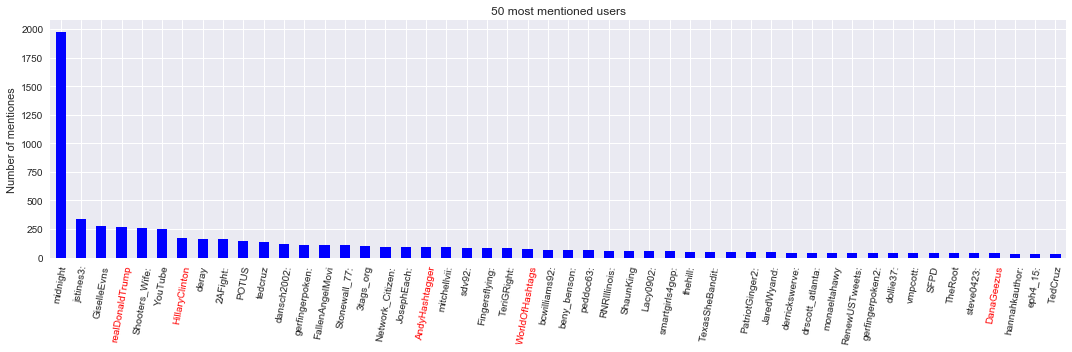

In [64]:
# Show users
fig = plt.figure(num=None, figsize=(15, 5))
top_users.plot.bar(color = 'blue')
plt.ylabel('Number of mentiones')
plt.title('50 most mentioned users')
plt.xticks(rotation=80)
plt.grid(True)
ax = plt.gca()

fig.set_tight_layout(True)

for xtick in ax.get_xticklabels():
    if xtick.get_text() == 'realDonaldTrump' or xtick.get_text() == 'AndyHashtagger' or xtick.get_text() == 'HillaryClinton' or xtick.get_text() == 'WorldOfHashtags'  or xtick.get_text() == 'FBI' or xtick.get_text() == 'DanaGeezus':
        xtick.set_color('red')
plt.show()
fig.savefig('mentioned_users.png')

## Find if user exists in data

In [65]:
mentioned_authors = []
authors = set(data.author.values)
for user in users_mentioned:
    if user.upper() in authors:
        mentioned_authors.append(user.upper())
mentioned_authors = pd.Series(mentioned_authors)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



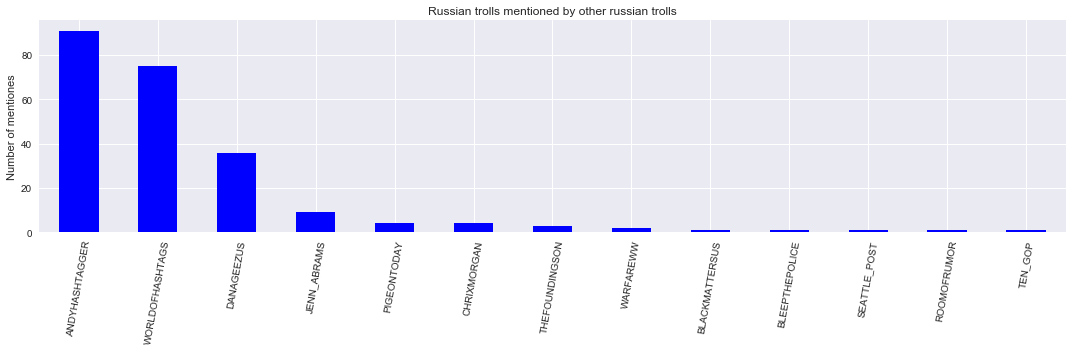

In [66]:
fig = plt.figure(num=None, figsize=(15, 5))
mentioned_authors.value_counts().plot.bar(color = 'blue')
plt.ylabel('Number of mentiones')
plt.title('Russian trolls mentioned by other russian trolls')
plt.xticks(rotation=80)
plt.grid(True)
fig.set_tight_layout(True)
plt.show()
fig.savefig('trolls_mentioning_other_trolls.png')

## Show 10 Tweets of 3 most mentioned trolls

In [68]:
andy_hashtager = data.groupby('author').get_group('ANDYHASHTAGGER')
most_retweeted = andy_hashtager.sort_values(by='retweet_count', ascending=False)
most_liked = andy_hashtager.sort_values(by='like_count', ascending=False)
most_replied = andy_hashtager.sort_values(by='reply_count', ascending=False)
print('USER: ANDYHASHTAGER, CATEGORY: {} with {} followers'.format(andy_hashtager.account_category.values[0]
    ,andy_hashtager.followers.max()))
i = 0
print('Most Retweets')
print('')
for tweet, date in zip(most_retweeted.tweet_text, most_retweeted.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1
i = 0
print('')
print('*************')
print('Most Likes')
print('')

for tweet, date in zip(most_liked.tweet_text, most_liked.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1
    
i = 0
print('')
print('*************')
print('Most Replies')
print('')
for tweet, date in zip(most_replied.tweet_text, most_replied.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1  
    
wordofhashtags = data.groupby('author').get_group('WORLDOFHASHTAGS')
most_retweeted = wordofhashtags.sort_values(by='retweet_count', ascending=False)
most_liked = wordofhashtags.sort_values(by='like_count', ascending=False)
most_replied = wordofhashtags.sort_values(by='reply_count', ascending=False)
i = 0
print('USER: WORLDOFHASHTAGS, CATEGORY: {} with {} followers'.format(wordofhashtags.account_category.values[0]
                                                                     ,wordofhashtags.followers.max()))
print('Most Retweets')
print('')
for tweet, date in zip(most_retweeted.tweet_text, most_retweeted.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1
i = 0
print('')
print('*************')
print('Most Likes')
print('')

for tweet, date in zip(most_liked.tweet_text, most_liked.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1
    
i = 0
print('')
print('*************')
print('Most Replies')
print('')
for tweet, date in zip(most_replied.tweet_text, most_replied.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1  
    
danageezus = data.groupby('author').get_group('DANAGEEZUS')
most_retweeted = danageezus.sort_values(by='retweet_count', ascending=False)
most_liked = danageezus.sort_values(by='like_count', ascending=False)
most_replied = danageezus.sort_values(by='reply_count', ascending=False)
i = 0
print('USER: DANAGEEZUS, CATEGORY: {} with {} followers,'.format(danageezus.account_category.values[0],danageezus.followers.max()))
print('Most Retweets')
print('')
for tweet, date in zip(most_retweeted.tweet_text, most_retweeted.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1
i = 0
print('')
print('*************')
print('Most Likes')
print('')

for tweet, date in zip(most_liked.tweet_text, most_liked.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1
    
i = 0
print('')
print('*************')
print('Most Replies')
print('')
for tweet, date in zip(most_replied.tweet_text, most_replied.publish_date):
    print('{} \n {}'.format(tweet, date))
    if i > 9:
        break
    i = i + 1    

USER: ANDYHASHTAGER, CATEGORY: HashtagGamer with 23890 followers
Most Retweets

#ThingsIWontBelieve this church sign https://t.co/BY7GlfV8X0 
 2016-06-29 21:05:00
Order your fries #MarriageAdviceIn3Words @midnight http://t.co/RuZwbcoy9a 
 2015-09-15 09:41:00
#IShouldBeWrappingPresentsBut kids get too much presents nowadays https://t.co/dTFLZozYDk 
 2015-12-24 15:28:00
#ItsTimeToPanicWhen Jesus is not coming back https://t.co/WB6MVbh9jG 
 2016-02-22 15:21:00
#IHatePokemonGoBecause cops won't help me to catch them! https://t.co/9snrQKm9nW 
 2016-07-30 15:23:00
#ToFeelBetterI try to give little girl my pneumonia #HillarysBodyDouble https://t.co/zCMbngLJaA 
 2016-09-12 13:28:00
#WhenIWasYoung this was the best graphics ever https://t.co/6wuBQlN5it 
 2016-06-01 14:34:00
#WhenIWasYoung it was our fault we didn’t do our homework https://t.co/WfNKee3CZi 
 2016-06-01 14:10:00
#HowToGetMediaAttention Choose a pregnancy outfit to look like killer whale https://t.co/qpsbvBh6si 
 2016-08-22 13:18:0

# Identical Tweets and Different Authors

## Select only tweets written by users

In [90]:
# only take original tweets
original_tweets = data.loc[data['post_type'] == 'TWEET']

# count number of original tweets
value_counts = original_tweets.tweet_text.value_counts().to_dict()
original_tweets.loc[:, 'Repetitions'] = original_tweets.tweet_text.apply(lambda x: value_counts[x])
original_tweets.loc[:, 'date'] = original_tweets.publish_date.apply(lambda x: np.datetime64(x, 'D'))

## Take tweets that are repeated only more than 15 times and count number of repetitions

In [91]:
repeated_tweets = original_tweets[['tweet_text', 'Repetitions', 'topic']].drop_duplicates(subset='tweet_text')
repeated_tweets = repeated_tweets[repeated_tweets['Repetitions'] > 15]
repeated_tweets = repeated_tweets.sort_values(by='Repetitions', ascending=False)
#pd.options.display.max_colwidth = 700
tweet_index = dict()
i = 1
political = []
for tweet in repeated_tweets.tweet_text.values:
    tweet_index[tweet] = "Tweet " + str(i)
    if i in [1,6,8,9,11,15,17,18,19,20,21,22,23,24,25,26,27]:
        political.append('POLITICAL')
    else:
        political.append('NON-POLITICAL')
    i = i + 1
top_tweet_text = list(tweet_index.keys())
repeated_tweets['tweet_text'] = tweet_index.values()
repeated_tweets['political'] = political
repeated_tweets.set_index('tweet_text', inplace=True)
repeated_tweets.head()

,Repetitions,topic,political
tweet_text,,,
Tweet 1,217,Black,POLITICAL
Tweet 2,121,Sports,NON-POLITICAL
Tweet 3,97,Foreign Countries,NON-POLITICAL
Tweet 4,79,Entertainment,NON-POLITICAL
Tweet 5,72,Entertainment,NON-POLITICAL


## Count number of distinct authors and distinct dates per tweet

In [92]:
frequent_author = original_tweets[original_tweets['tweet_text'].isin(top_tweet_text)].groupby('tweet_text')
number_of_authors = []
tweets = []
for name, group in frequent_author:
    number_of_authors.append(group.author.value_counts().shape[0])
    tweets.append(tweet_index[name])
authors_count = pd.DataFrame(data = number_of_authors, index=tweets, columns=['Distinct Authors'])
frequent_dates = original_tweets[original_tweets['tweet_text'].isin(top_tweet_text)].groupby('tweet_text')
different_dates = []
tweets = []
dates = []
for name, group in frequent_dates:
    different_dates.append(group.date.value_counts().shape[0])
    tweets.append(tweet_index[name])
date_count = pd.DataFrame(data = different_dates, index=tweets, columns=['Distinct Dates'])
repeated_tweets = repeated_tweets.join(authors_count, how='left')
repeated_tweets = repeated_tweets.join(date_count, how='left')
repeated_tweets.head()

,Repetitions,topic,political,Distinct Authors,Distinct Dates
tweet_text,,,,,
Tweet 1,217,Black,POLITICAL,88,15
Tweet 2,121,Sports,NON-POLITICAL,1,121
Tweet 3,97,Foreign Countries,NON-POLITICAL,1,96
Tweet 4,79,Entertainment,NON-POLITICAL,1,70
Tweet 5,72,Entertainment,NON-POLITICAL,1,66


## Plot Results in a bar plot

<Figure size 576x396 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



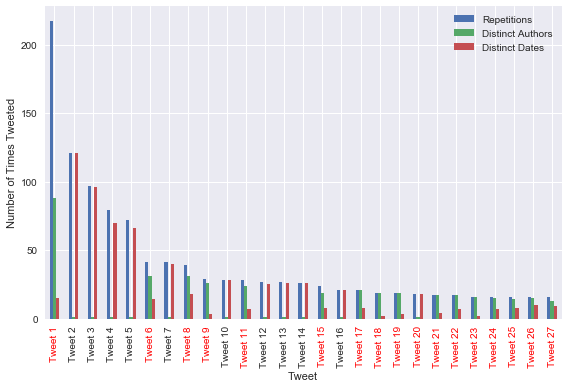

In [93]:
fig = plt.figure(num=None)
no_duplicates[['Repetitions', 'Distinct Authors', 'Distinct Dates']].plot.bar()
plt.ylabel('Number of Times Tweeted')
#plt.title('Repeated Tweets')
plt.xlabel('Tweet')
plt.xticks(rotation=90)
plt.grid(True)
ax = plt.gca()
for xtick in ax.get_xticklabels():
    if no_duplicates.loc[xtick.get_text()].political == 'POLITICAL':
        xtick.set_color('red')
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig('number_duplicates.png')
plt.show()

##  Plot Distinct Dates  as a function of Distinct Authors

<Figure size 576x396 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



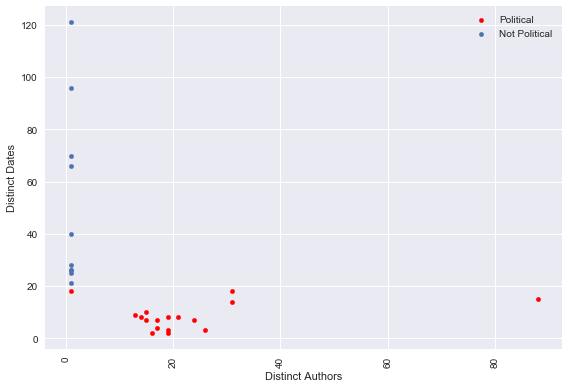

In [94]:
fig = plt.figure(num=None)
only_political = no_duplicates[['Distinct Authors', 'Distinct Dates']][no_duplicates['political'] == 'POLITICAL']
not_political = no_duplicates[['Distinct Authors', 'Distinct Dates']][no_duplicates['political'] == 'NON-POLITICAL']
ax1 = only_political.plot.scatter(x='Distinct Authors', y = 'Distinct Dates', label='Political', color='red')
not_political.plot.scatter(x='Distinct Authors', y = 'Distinct Dates', label='Not Political', ax=ax1)
plt.ylabel('Distinct Dates')
#plt.title('Repeated Tweets')
plt.xlabel('Distinct Authors')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig('scatter.png')
plt.show()

## Repeat analysis for tweets repeated 5 times or more

In [95]:
repeated_tweets = original_tweets[['tweet_text', 'Repetitions', 'topic']].drop_duplicates(subset='tweet_text')
repeated_tweets = repeated_tweets[repeated_tweets['Repetitions'] >= 5]
repeated_tweets = repeated_tweets.sort_values(by='Repetitions', ascending=False)
political = []
for topic in repeated_tweets.topic:
    if topic in ['Crime', 'Entertainment', 'Sports', 'Health']:
        political.append('NON-POLITICAL')
    else:
        political.append('POLITICAL')
repeated_tweets['political'] = political
repeated_tweets.set_index('tweet_text', inplace=True)
repeated_tweets.head()

,Repetitions,topic,political
tweet_text,,,
NewsOne Now Audio Podcast: Bishop E.W. Jackson Calls #BlackLivesMatter Is Movement “Disgraceful”,217,Black,POLITICAL
Honor scores #sports,121,Sports,NON-POLITICAL
SE Wis. road construction projects #Wisconsin,97,Foreign Countries,POLITICAL
Celebrity style: Red carpet looks #celebs #news,79,Entertainment,NON-POLITICAL
Daily Celebrity Watch #celebs #news,72,Entertainment,NON-POLITICAL


In [96]:
frequent_author = original_tweets[original_tweets['tweet_text'].isin(repeated_tweets.index.values)].groupby('tweet_text')
number_of_authors = []
tweets = []
for name, group in frequent_author:
    number_of_authors.append(group.author.value_counts().shape[0])
    tweets.append(name)
authors_count = pd.DataFrame(data = number_of_authors, index=tweets, columns=['Distinct Authors'])
frequent_dates = original_tweets[original_tweets['tweet_text'].isin(repeated_tweets.index.values)].groupby('tweet_text')
different_dates = []
tweets = []
dates = []
for name, group in frequent_dates:
    different_dates.append(group.date.value_counts().shape[0])
    tweets.append(name)
date_count = pd.DataFrame(data = different_dates, index=tweets, columns=['Distinct Dates'])
repeated_tweets = repeated_tweets.join(authors_count, how='left')
repeated_tweets = repeated_tweets.join(date_count, how='left')

##  Plot Distinct Dates  as a function of Distinct Authors

<Figure size 576x396 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



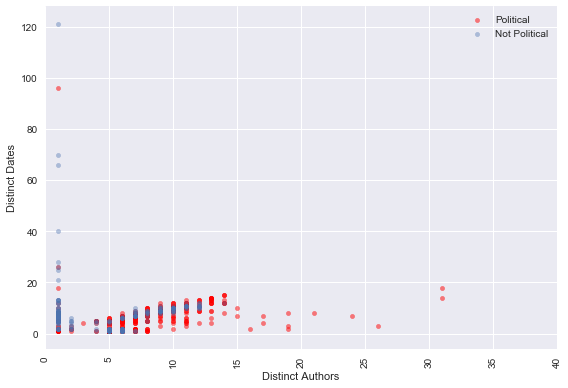

In [97]:
fig = plt.figure(num=None)
only_political = repeated_tweets[['Distinct Authors', 'Distinct Dates']][repeated_tweets['political'] == 'POLITICAL']
not_political = repeated_tweets[['Distinct Authors', 'Distinct Dates']][repeated_tweets['political'] == 'NON-POLITICAL']
ax1 = only_political.plot.scatter(x='Distinct Authors', y = 'Distinct Dates', label='Political', color='red', alpha=0.5)
not_political.plot.scatter(x='Distinct Authors', y = 'Distinct Dates', label='Not Political', ax=ax1, alpha=0.4)
plt.ylabel('Distinct Dates')
plt.xlabel('Distinct Authors')
plt.xticks(rotation=90)
plt.xlim([0, 40])
plt.grid(True)
plt.legend()

fig = plt.gcf()
fig.set_tight_layout(True)

fig.savefig('scatter2.png')
plt.show()

## Calculate Statistical Significance

In [98]:
x = only_political['Distinct Authors'].values
np.random.shuffle(x)
x = x[:200]

y = not_political['Distinct Authors'].values
np.random.shuffle(y)
y = y[:200]
_, p_value = wilcoxon(x=x, y=y, zero_method='wilcox')
p_value

6.015439284216994e-11